In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE
from scipy.optimize import linear_sum_assignment
from typing import Literal

from bfr import BFR
from utils import Dataset

# Helper Functions


In [ ]:
def normalize_df(
    df_train: pd.DataFrame,
    df_tests: list[pd.DataFrame],
    norm_cols: list[str],
    method: Literal["min-max", "standard"] = "min-max",
):
    scaler = MinMaxScaler() if method == "min-max" else StandardScaler()
    scaler.fit(df_train[norm_cols])

    df_norm_train = df_train.copy()
    df_norm_test = []

    df_norm_train[norm_cols] = scaler.transform(df_train[norm_cols])

    for df in df_tests:
        df_norm = df.copy()
        df_norm[norm_cols] = scaler.transform(df[norm_cols])
        df_norm_test.append(df_norm)

    return df_norm_train, df_norm_test, scaler

In [4]:
def encode_labels(df: pd.DataFrame):
    label_encoder = LabelEncoder()

    encoded_cols = []

    for column in df.columns:
        if df[column].dtype == "object":
            encoded_cols.append(column)

            df[column] = label_encoder.fit_transform(df[column])

    return df, encoded_cols, label_encoder

In [6]:
def plot_corr_matrix(df: pd.DataFrame):
    corr_matrix = df.corr()

    # Create heatmap plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr_matrix,
        annot=True,
        cmap="coolwarm",
        linewidths=0.2,
        linecolor="white",
    )

    # Customize plot
    plt.title("Correlation Matrix")
    plt.tight_layout()

    # Display plot
    plt.show()

    return corr_matrix

In [7]:
def plot_tsne(
    data,
    labels,
    perplexity=30,
    n_iter=300,
):
    tsne = TSNE(
        perplexity=perplexity,
        max_iter=n_iter,
        random_state=SEED,
        n_components=2,
    )
    tsne_results = tsne.fit_transform(data)

    df_tsne = pd.DataFrame(tsne_results, columns=["X", "Y"])
    df_tsne["label"] = labels

    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x="X",
        y="Y",
        hue="label",
        palette=sns.color_palette("hsv", len(np.unique(labels))),
        data=df_tsne,
        legend="full",
        alpha=0.7,
    )

    plt.title("t-SNE Plot")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.show()

In [ ]:
def plot_crosstab(y_names: np.ndarray, y_hat: np.ndarray):
    crosstab = pd.crosstab(
        y_names,
        y_hat,
        rownames=["True Labels"],
        colnames=["Predicted Labels"],
        normalize="all",
    )

    plt.figure(figsize=(12, 12))
    sns.heatmap(crosstab, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.show()

    acc = np.trace(crosstab.values)

    print(f"Accuracy is {acc * 100:0.2f}%")


In [11]:
def find_best_matching(y_true: np.ndarray, y_pred: np.ndarray):
    def create_cost_matrix():
        num_y_true = len(np.unique(y_true))
        num_y_pred = len(np.unique(y_pred))

        cost_matrix = np.zeros((num_y_true, num_y_pred), dtype=int)

        for i, y in enumerate(np.unique(y_true)):
            for j, y_hat in enumerate(np.unique(y_pred)):
                cost_matrix[i, j] = np.sum((y_true == y) & (y_pred == y_hat))

        return -cost_matrix

    def hungarian_method(cost_matrix):
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        return row_ind, col_ind

    cost_matrix = create_cost_matrix()
    row_ind, col_ind = hungarian_method(cost_matrix)

    new_y_pred = np.zeros_like(y_true)

    for true_i, pred_i in zip(row_ind, col_ind):
        idx = np.where(y_pred == pred_i)[0]
        new_y_pred[idx] = true_i

    return new_y_pred


## EDA


In [ ]:
df_songs = pd.read_csv("songs.csv", low_memory=False)

In [13]:
drop_cols = [
    "type",
    "id",
    "uri",
    "track_href",
    "analysis_url",
    "time_signature",
    "song_name",
    "Unnamed: 0",
    "title",
]

df_songs.drop(columns=drop_cols, inplace=True)

In [14]:
df_songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42305 entries, 0 to 42304
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      42305 non-null  float64
 1   energy            42305 non-null  float64
 2   key               42305 non-null  int64  
 3   loudness          42305 non-null  float64
 4   mode              42305 non-null  int64  
 5   speechiness       42305 non-null  float64
 6   acousticness      42305 non-null  float64
 7   instrumentalness  42305 non-null  float64
 8   liveness          42305 non-null  float64
 9   valence           42305 non-null  float64
 10  tempo             42305 non-null  float64
 11  duration_ms       42305 non-null  int64  
 12  genre             42305 non-null  object 
dtypes: float64(9), int64(3), object(1)
memory usage: 4.2+ MB


In [15]:
df_songs.isna().sum()

danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
genre               0
dtype: int64

In [16]:
df_songs = df_songs.drop_duplicates()

In [17]:
df_songs, _, songs_genre_encoder = encode_labels(df_songs)

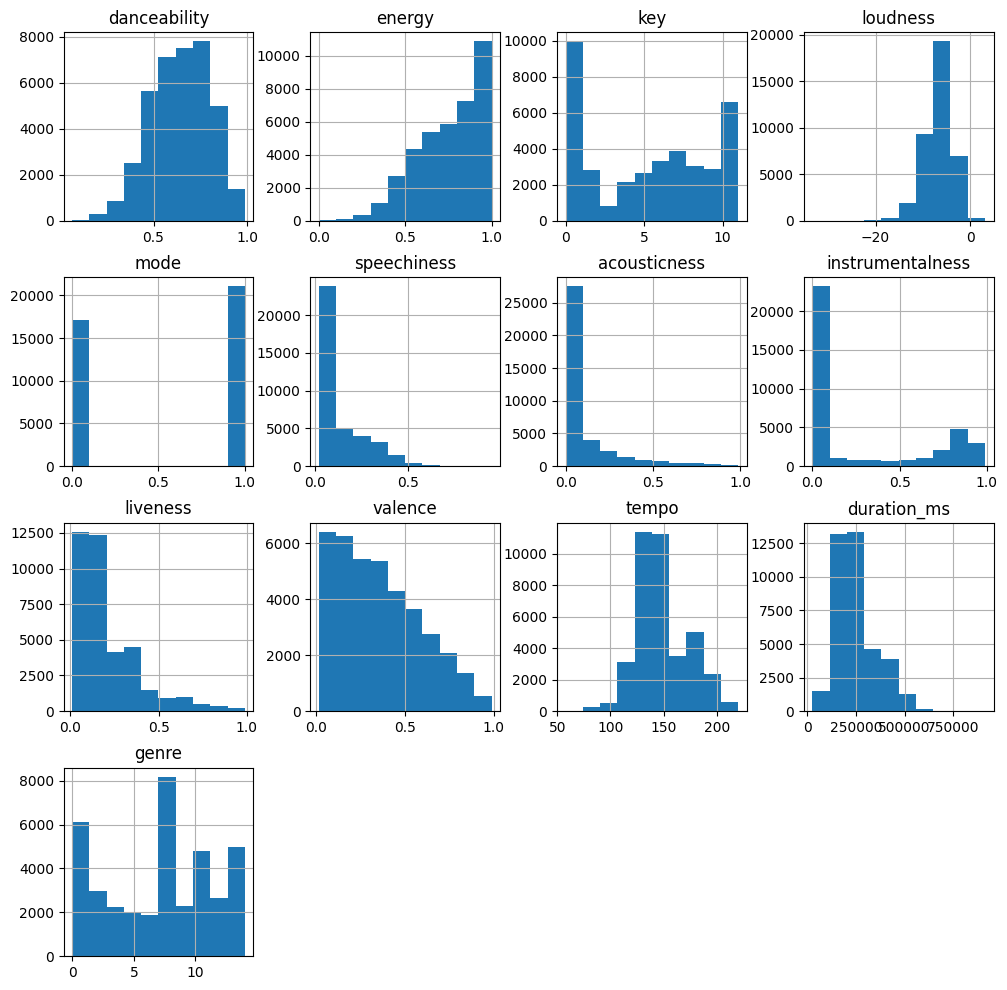

In [18]:
df_songs.hist(figsize=(12, 12))
plt.show()

In [ ]:
norm_cols = df_songs.columns.drop(["key", "mode", "genre"])

df_songs, _, _ = normalize_df(df_songs, [], norm_cols, "standard")

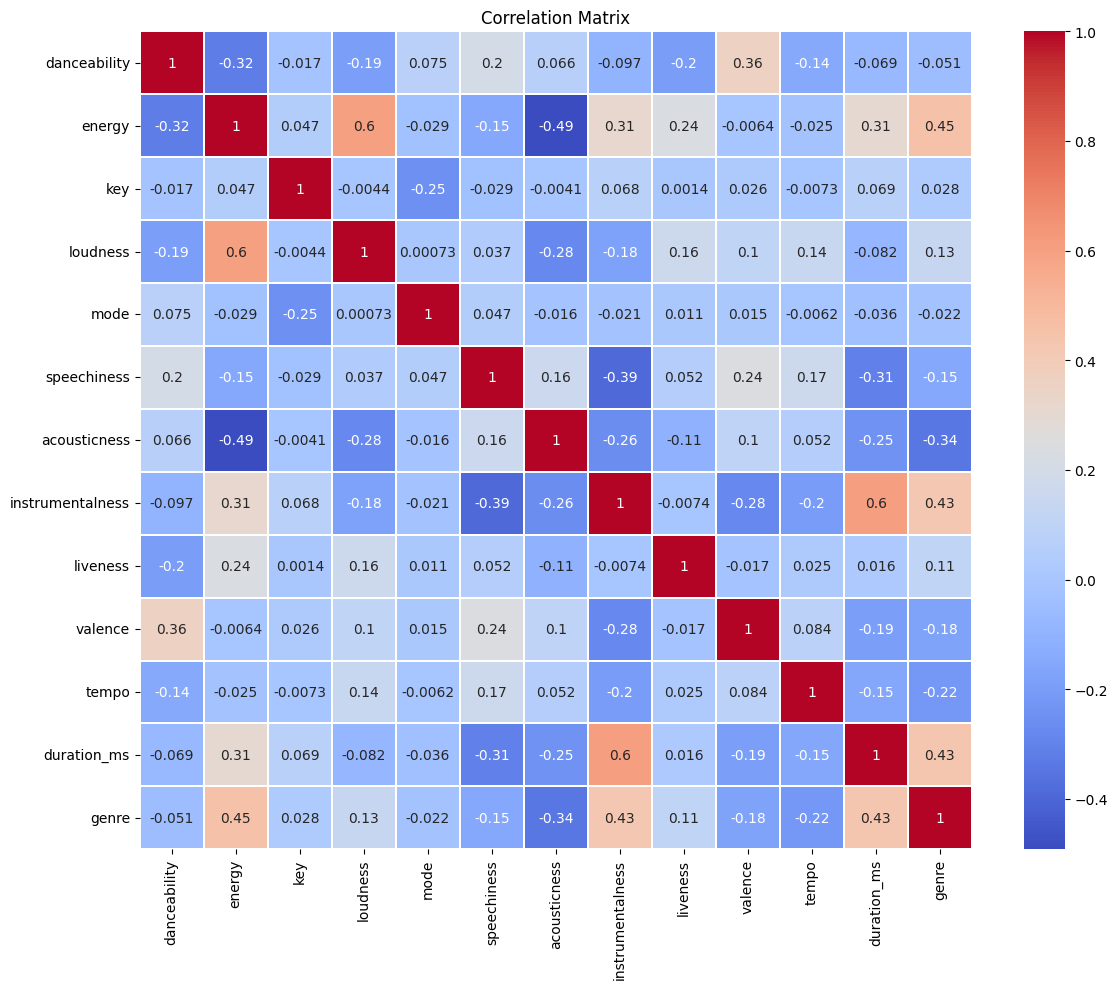

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,genre
danceability,1.000000,-0.321181,-0.016788,-0.193622,0.074900,0.197365,0.065968,-0.097132,-0.195631,0.355678,-0.143612,-0.068713,-0.051396
energy,-0.321181,1.000000,0.046916,0.598255,-0.029413,-0.151535,-0.492025,0.312564,0.235523,-0.006411,-0.024569,0.305524,0.454754
key,-0.016788,0.046916,1.000000,-0.004391,-0.249563,-0.029004,-0.004118,0.067519,0.001421,0.025913,-0.007304,0.068822,0.027705
loudness,-0.193622,0.598255,-0.004391,1.000000,0.000733,0.036799,-0.280694,-0.179643,0.163360,0.102817,0.140004,-0.082269,0.132853
mode,0.074900,-0.029413,-0.249563,0.000733,1.000000,0.047004,-0.016440,-0.021459,0.011071,0.014906,-0.006237,-0.036341,-0.022379
speechiness,0.197365,-0.151535,-0.029004,0.036799,0.047004,1.000000,0.158254,-0.389283,0.051708,0.240260,0.166450,-0.311060,-0.153203
acousticness,0.065968,-0.492025,-0.004118,-0.280694,-0.016440,0.158254,1.000000,-0.262094,-0.109842,0.101458,0.051671,-0.247061,-0.342566
instrumentalness,-0.097132,0.312564,0.067519,-0.179643,-0.021459,-0.389283,-0.262094,1.000000,-0.007394,-0.280618,-0.200652,0.604671,0.428233
liveness,-0.195631,0.235523,0.001421,0.163360,0.011071,0.051708,-0.109842,-0.007394,1.000000,-0.016666,0.024978,0.016345,0.107190
valence,0.355678,-0.006411,0.025913,0.102817,0.014906,0.240260,0.101458,-0.280618,-0.016666,1.000000,0.083810,-0.193626,-0.176254


In [20]:
plot_corr_matrix(df_songs)

In [21]:
k_songs = df_songs["genre"].nunique()

x_songs = df_songs.drop(columns=["genre"]).to_numpy()
y_songs = df_songs["genre"].to_numpy()

s_songs = Dataset(x_songs, y_songs)

## Training


In [22]:
bfr_ds_thresh = 0.25
bfr_cs_rs_thresh = 2
bfr_cs_thresh = 4
bfr_batch_size = 10
bfr_num_samples = 128

bfr = BFR(
    k_songs,
    bfr_batch_size,
    bfr_ds_thresh,
    bfr_cs_rs_thresh,
    bfr_cs_thresh,
)

In [23]:
bfr.fit(s_songs.x, bfr_num_samples)

Reading data in Batches:   0%|          | 0/3800 [00:00<?, ?it/s]

Merging CS: 100%|██████████| 35292601/35292601 [11:18<00:00, 52006.48it/s]


In [24]:
y_hat = bfr.predict(s_songs.x)

Reading data in Batches: 100%|██████████| 3813/3813 [00:00<00:00, 5192.65it/s]


## Plotting


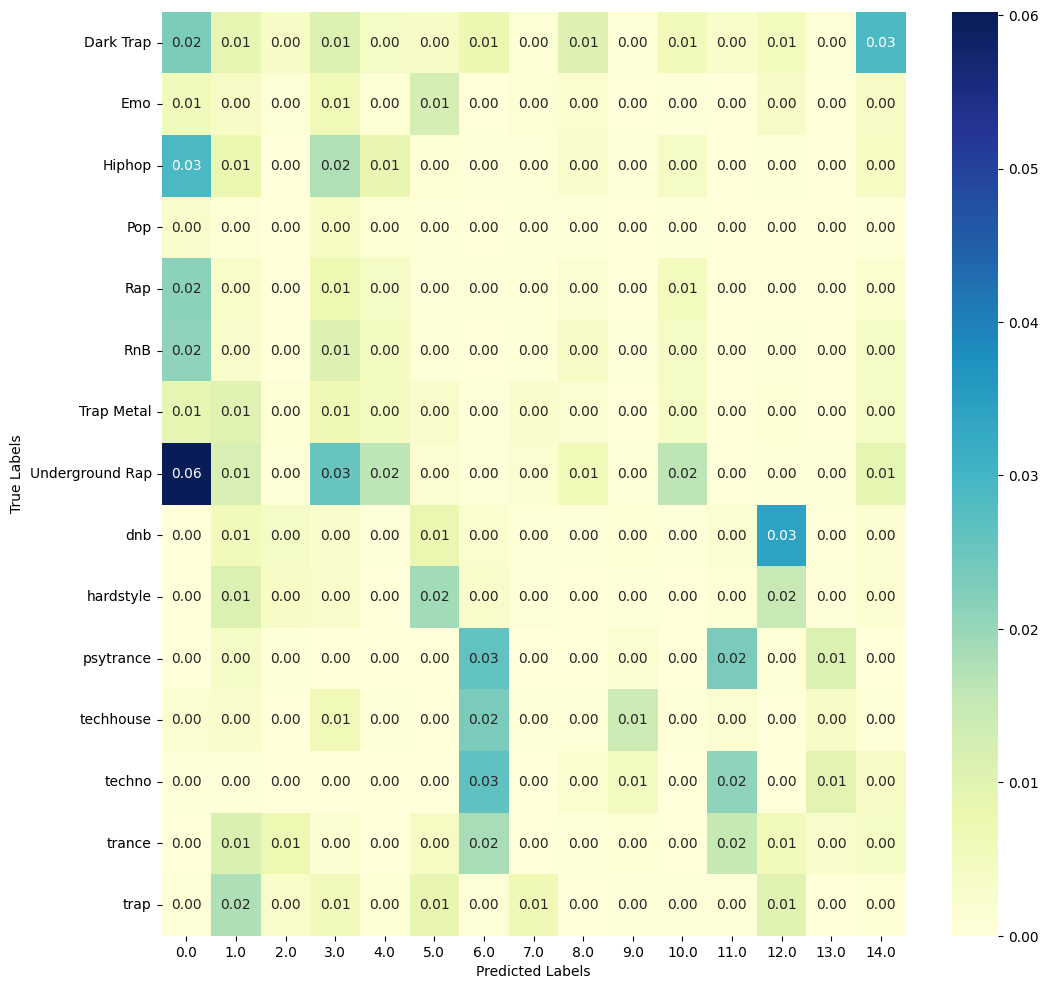

Accuracy is 4.36%


In [25]:
y_names = songs_genre_encoder.inverse_transform(s_songs.y)
# y_hat_names = songs_genre_encoder.inverse_transform(y_hat.astype(np.int32))

plot_crosstab(y_names, y_hat)

In [26]:
new_y_pred = find_best_matching(s_songs.y, y_hat)

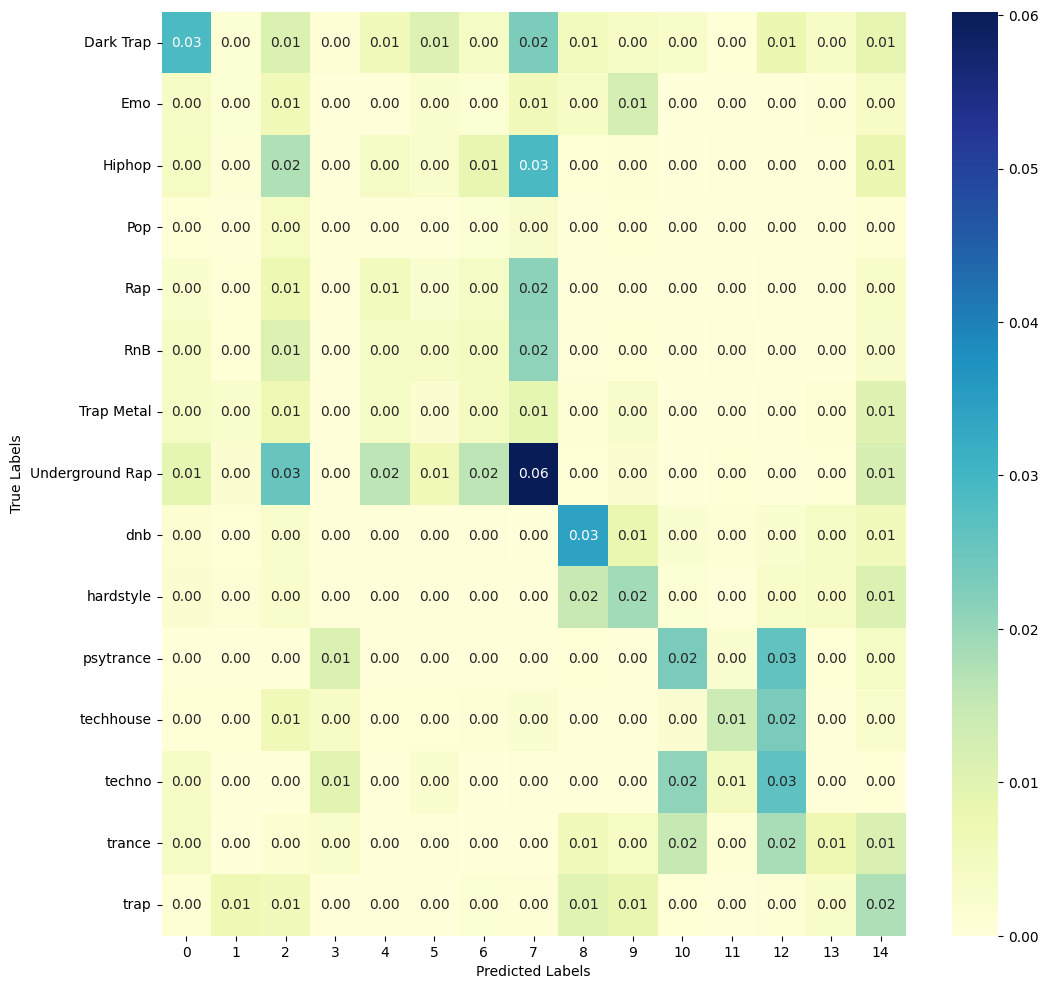

Accuracy is 26.36%


In [27]:
plot_crosstab(y_names, new_y_pred)

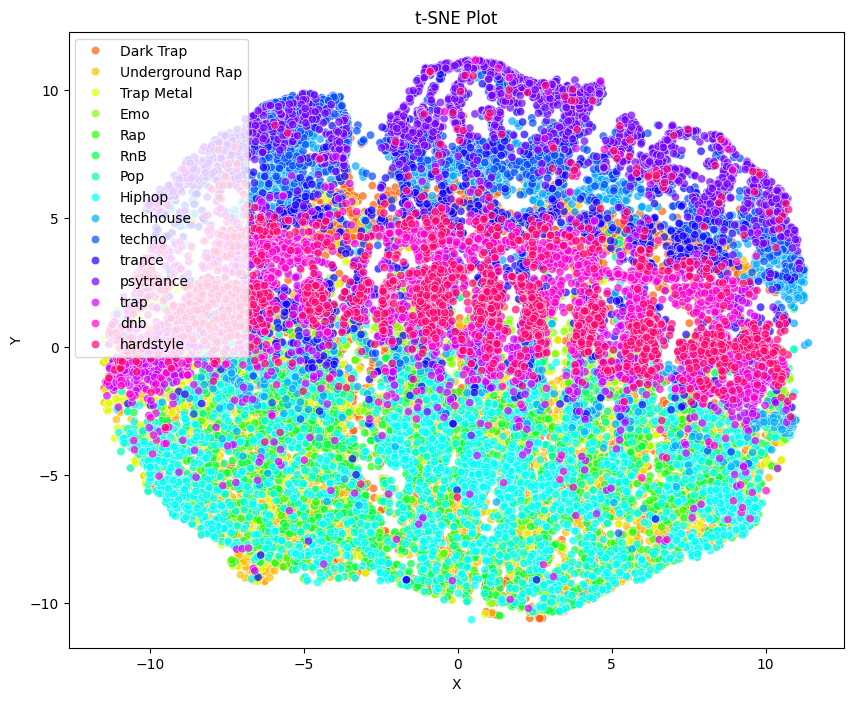

In [28]:
plot_tsne(s_songs.x, y_names)

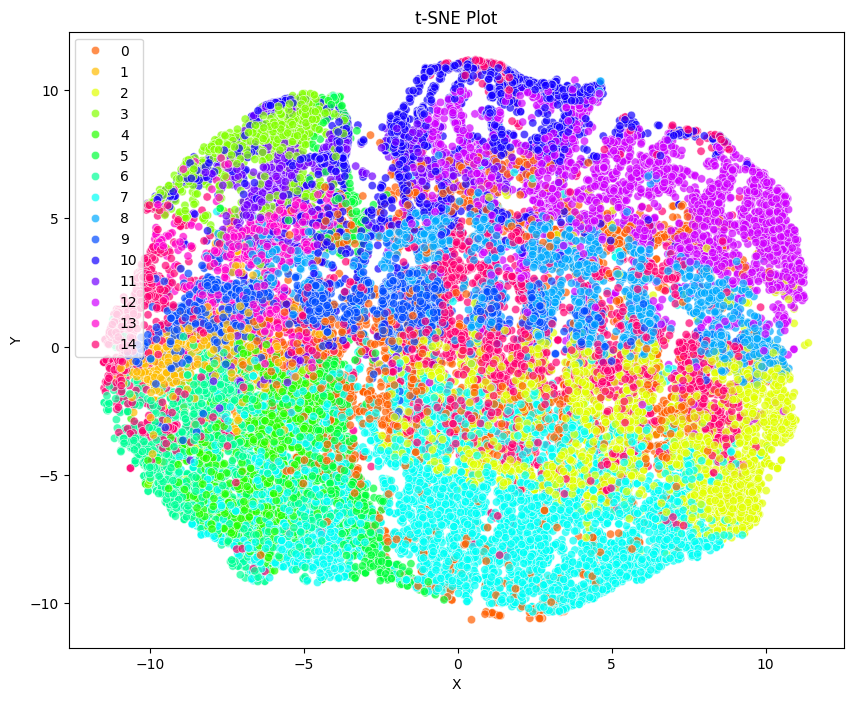

In [29]:
plot_tsne(s_songs.x, new_y_pred)
